<a href="https://colab.research.google.com/github/zzskyy0301/ML_PROJECT/blob/main/VGG%26mobilenet_POSTER_advGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataloader**

In [7]:
import matplotlib.pyplot as plt
import csv
from collections import defaultdict, namedtuple
import os
import shutil
import pandas as pd
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image
import numpy as np
import torchvision.models as models
import glob as glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
#@title GTSRB_Net
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab.patches import cv2_imshow

In [ ]:
#!unzip /content/drive/MyDrive/adversarial/GTSRB_Final_Training_Images.zip -d /content/drive/MyDrive/adversarial
#!unzip -d

In [ ]:
#! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P /content/drive/MyDrive/adversarial

--2022-07-18 08:12:59--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘/content/drive/MyDrive/adversarial/signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2022-07-18 08:12:59 (37.3 MB/s) - ‘/content/drive/MyDrive/adversarial/signnames.csv’ saved [999/999]



In [8]:
def load_training_annotations(source_path):
    annotations = {}
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        #print(filename)
        with open(filename) as f:
          reader = csv.reader(f, delimiter=';')
          next(reader) # skip header

          # loop over all images in current annotations file
          for row in reader:
              #print(row)
              filename = row[0] # filename is in the 0th column
              width = float(row[1])
              height = float(row[2])
              x1=float(row[3])/float(width)
              y1=float(row[4])/float(height)
              x2=float(row[5])/float(width)
              y2=float(row[6])/float(height)
              label = int(row[7]) # label is in the 7th column
        
              annotations[filename]={'width':width,
                               'height':height,
                               'x1':x1,
                               'y1':y1,
                               'x2':x2,
                               'y2':y2,
                               'label':label}
    return annotations


In [10]:
annotations = load_training_annotations('/content/drive/MyDrive/adversarial/GTSRB/Final_Training/Images')

In [11]:

class GTSRB_dataloader(data.Dataset):
    def __init__(self, opt):
        super(GTSRB_dataloader, self).__init__()
        self.image_list = []
        self.root = opt['dataroot']
        self.batch_size = opt['batch_size']
        self.transform = opt['transform']
        self.mode = opt['mode']
        self.annotations = opt['annotations']
        self.tranform = opt['transform']
        self._assertValid()
        #self.epoch = opt['epoch']
        #self.img_list = os.listdir(opt.dataroot) #data root: .training/Image/
        #self.num_labels = 2
        #self.mean = [0.485, 0.456, 0.406]
        #self.std = [0.229, 0.224, 0.225]
        #self._assertValid()
    
    def _assertValid(self):
      for files in os.listdir(self.root):
          for file in os.listdir(os.path.join(self.root,files)):
            if file.endswith(".ppm"):
                 self.image_list.append(os.path.join(self.root, files,file))
      
      assert len(self.image_list)>0, "Not able to locate image data"
        
    def __getitem__(self,index):
        #img_path = os.listdir(os.path.join(),suffix == 'ppm')
        img = Image.open(self.image_list[index])
        img_name =os.path.basename(self.image_list[index])
        if img is None:
            return {}
        if self.transform is not None:
            img = self.transform(img)
           
        img_anno = self.annotations[img_name]
        img_anno ['img_name'] = img_name
        img_anno ['width'] = img.shape[1]
        img_anno ['height']= img.shape[2]
        return {'image': img, 
                
                'annotation':img_anno}
    def __len__(self):
        return len(self.image_list)

## try the loader

tensor([4.], dtype=torch.float64) tensor([3.9184], dtype=torch.float64) tensor([28.], dtype=torch.float64) tensor([28.7347], dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  points = np.array(args, dtype=float).reshape(2, 2)


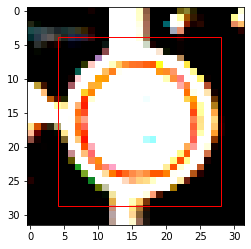

In [ ]:

opt = {"dataroot": '/content/drive/MyDrive/adversarial/GTSRB/Final_Training/Images', 
   "batch_size": 1,
   "transform": None,
   "mode": "train", 
   "annotations": annotations,
   'transform': transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))])}
dataset = GTSRB_dataloader(opt)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = opt["batch_size"], shuffle=True)
for idx, batch in enumerate(dataloader):
    if idx ==0:
      img = batch['image']
      img = img.numpy()
      img = np.squeeze(img, axis=0)
      img = np.transpose(img, (1,2,0))
      xmin = batch['annotation']['width']*batch['annotation']['x1']
      ymin = batch['annotation']['height']*batch['annotation']['y1']
      xmax = batch['annotation']['width']*batch['annotation']['x2']
      ymax = batch['annotation']['height']*batch['annotation']['y2']
      print(xmin,ymin,xmax,ymax)
      fig, ax = plt.subplots()
      ax.imshow(img)
      rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

      plt.show()
      # cv2.rectangle(img,
      #               (batch['annotation']['width']*batch['annotation']['x1'],batch['annotation']['height']*batch['annotation']['y1']),
      #               (batch['annotation']['width']*batch['annotation']['x2'],batch['annotation']['height']*batch['annotation']['y2']),
      #               (255,0,0),2)
      #plt.imshow(img)
      
      break


# **Models.py**

In [ ]:

nclasses = 43 # GTSRB as 43 classes

class GTSRB_Net(nn.Module):
    def __init__(self):
        super(GTSRB_Net, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(3, 100, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(250)
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(250*2*2, 350)
        self.fc2 = nn.Linear(350, nclasses)

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
            )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
            )
   
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))


    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform forward pass
        x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
        x = self.conv_drop(x)
        x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
        x = self.conv_drop(x)
        x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
        x = self.conv_drop(x)
        x = x.view(-1, 250*2*2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        test = F.log_softmax(x, dim=1)
        #print(test.shape)
        return F.log_softmax(x, dim=1)

SOURCE:https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/YOLOv3/dataset.py

In [ ]:


""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x


class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1
            ),
        )
        self.num_classes = num_classes

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )


class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers


if __name__ == "__main__":
    num_classes = 20
    IMAGE_SIZE = 64
    model = YOLOv3(num_classes=num_classes)
    x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
    out = model(x)
    print(out)
    assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
    assert model(x)[1].shape == (2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
    assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
    print("Success!")

In [ ]:
out[0].shape

torch.Size([2, 3, 2, 2, 25])

## **VGG-16** 

## D&G

In [12]:
#@title Poster Discriminator & Generator


class Discriminator(nn.Module):
    def __init__(self, image_nc):
        super(Discriminator, self).__init__()
        # MNIST: 1*28*28
        model = [
            nn.Conv2d(image_nc, 8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            # 8*13*13
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            # 16*5*5
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
            # 32*1*1
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output


class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            # MNIST:1*28*28
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*26*26
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # 16*12*12
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # 32*5*5
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # state size. 16 x 11 x 11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23
            nn.ConvTranspose2d(8, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
            # state size. image_nc x 28 x 28
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x

# Define a resnet block
# modified from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

# **advGAN.py**

In [13]:
#@title Poster Attack
import torch.nn as nn
import torch
import numpy as np

import torch.nn.functional as F
import torchvision
import os

models_path = './models/'


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class AdvGAN_Attack:
    def __init__(self,
                 device,
                 model,
                 model_num_labels,
                 image_nc,
                 box_min,
                 box_max):
        output_nc = image_nc
        self.device = device
        self.model_num_labels = model_num_labels
        self.model = model
        self.input_nc = image_nc
        self.output_nc = output_nc
        self.box_min = box_min
        self.box_max = box_max

        self.gen_input_nc = image_nc
        self.netG = Generator(self.gen_input_nc, image_nc).to(device)
        self.netDisc = Discriminator(image_nc).to(device)

        # initialize all weights
        self.netG.apply(weights_init)
        self.netDisc.apply(weights_init)

        # initialize optimizers
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                            lr=0.001)
        self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                            lr=0.001)

        if not os.path.exists(models_path):
            os.makedirs(models_path)

    def train_batch(self, x, labels):
        # optimize D
        for i in range(1):
            perturbation = self.netG(x)

            # add a clipping trick
            adv_images = torch.clamp(perturbation, -0.3, 0.3) + x
            adv_images = torch.clamp(adv_images, self.box_min, self.box_max)

            self.optimizer_D.zero_grad()
            pred_real = self.netDisc(x)
            loss_D_real = F.mse_loss(pred_real, torch.ones_like(pred_real, device=self.device))
            loss_D_real.backward()

            pred_fake = self.netDisc(adv_images.detach())
            loss_D_fake = F.mse_loss(pred_fake, torch.zeros_like(pred_fake, device=self.device))
            loss_D_fake.backward()
            loss_D_GAN = loss_D_fake + loss_D_real
            self.optimizer_D.step()

        # optimize G
        for i in range(1):
            self.optimizer_G.zero_grad()

            # cal G's loss in GAN
            pred_fake = self.netDisc(adv_images)
            loss_G_fake = F.mse_loss(pred_fake, torch.ones_like(pred_fake, device=self.device))
            loss_G_fake.backward(retain_graph=True)

            # calculate perturbation norm
            C = 0.1
            loss_perturb = torch.mean(torch.norm(perturbation.view(perturbation.shape[0], -1), 2, dim=1))
            # loss_perturb = torch.max(loss_perturb - C, torch.zeros(1, device=self.device))

            # cal adv loss
            logits_model = self.model(adv_images)
            probs_model = F.softmax(logits_model, dim=1)
            onehot_labels = torch.eye(self.model_num_labels, device=self.device)[labels]

            # C&W loss function
            real = torch.sum(onehot_labels * probs_model, dim=1)
            other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
            zeros = torch.zeros_like(other)
            loss_adv = torch.max(real - other, zeros)
            loss_adv = torch.sum(loss_adv)

            # maximize cross_entropy loss
            # loss_adv = -F.mse_loss(logits_model, onehot_labels)
            # loss_adv = - F.cross_entropy(logits_model, labels)

            adv_lambda = 10
            pert_lambda = 1
            loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb
            loss_G.backward()
            self.optimizer_G.step()

        return loss_D_GAN.item(), loss_G_fake.item(), loss_perturb.item(), loss_adv.item()

    def train(self, train_dataloader, epochs):
        for epoch in range(1, epochs+1):
            print(epoch%1==0)
            if epoch == 50:
                self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                                    lr=0.0001)
                self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                                    lr=0.0001)
            if epoch == 80:
                self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                                    lr=0.00001)
                self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                                    lr=0.00001)
            loss_D_sum = 0
            loss_G_fake_sum = 0
            loss_perturb_sum = 0
            loss_adv_sum = 0
            for i, data in enumerate(train_dataloader, start=0):
                images ,target = data['image'],data['annotation']
                labels = target['label']
      
                images, labels = images.to(self.device), labels.to(self.device)

                loss_D_batch, loss_G_fake_batch, loss_perturb_batch, loss_adv_batch = \
                    self.train_batch(images, labels)
                loss_D_sum += loss_D_batch
                loss_G_fake_sum += loss_G_fake_batch
                loss_perturb_sum += loss_perturb_batch
                loss_adv_sum += loss_adv_batch
                if i % 500 == 0:
                    print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                        epoch, i * len(data), len(train_dataloader.dataset),
                        loss_adv_sum))
                
            # # print statistics
            # num_batch = len(train_dataloader)
            # print("epoch %d:\nloss_D: %.3f, loss_G_fake: %.3f,\
            #  \nloss_perturb: %.3f, loss_adv: %.3f, \n" %
            #       (epoch, loss_D_sum/num_batch, loss_G_fake_sum/num_batch,
            #        loss_perturb_sum/num_batch, loss_adv_sum/num_batch))

            # save generator
            if epoch%1==0:
                netG_file_name = models_path + 'netG_epoch_' + str(epoch) + '.pth'
                torch.save(self.netG.state_dict(), netG_file_name)

# **main.py**

In [ ]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


use_cuda=True
image_nc=3
epochs = 3
BOX_MIN = 0
BOX_MAX = 1
model_num_labels = 43
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


#VGG-16
vgg16 =  models.vgg16(pretrained=True)
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, model_num_labels)]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

#mobilenet
mobileNet =models.mobilenet_v3_large(pretrained=True,progress=True)    
mobileNet.classifier[-1] = nn.Linear(1280, model_num_labels)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [ ]:
targeted_model = vgg16
targeted_model.to(device)
targeted_model.eval()

In [20]:
opt = {"dataroot": '/content/drive/MyDrive/adversarial/GTSRB/Final_Training/Images', 
   "batch_size": 32,
   "transform": None,
   "mode": "train", 
   "annotations": annotations,
   'transform': transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))])}

dataset =GTSRB_dataloader(opt)
dataloader = DataLoader(dataset, batch_size=opt['batch_size'], shuffle=True, num_workers=1)
advGAN = AdvGAN_Attack(device,
                          targeted_model,
                          model_num_labels,
                          image_nc,
                          BOX_MIN,
                          BOX_MAX)

advGAN.train(dataloader, epochs)

True
torch.Size([32, 43])
torch.Size([32, 43])
Train Epoch: 1 [0/39209]	Loss: 0.012349


KeyboardInterrupt: ignored

#**Train target model (GTSRB_NET)**

In [ ]:
def train(epoch):
    model.train()
    correct = 0
    training_loss = 0
    for batch_idx, image in enumerate(train_loader, 0):
        data ,target = image['image'],image['annotation']
        target = target['label']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        max_index = output.max(dim = 1)[1]
        correct += (max_index == target).sum()
        training_loss += loss
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss per example: {:.6f}\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.data.item()/(batch_size * 10),loss.data.item()))
    print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                training_loss / len(train_loader.dataset), correct, len(train_loader.dataset),
                100. * correct / len(train_loader.dataset)))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for batch_idx, image in val_loader:
        with torch.no_grad():
            data ,target = image['image'],image['annotation']
            target = target['label']
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    scheduler.step(np.around(validation_loss,2))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
###################################### main functions #################################
image_nc = 3
batch_size = 8
num_epoch = 1
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
	use_gpu = False
	print("Using CPU")
mnist_dataset = GTSRB_dataloader(opt)
train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model = GTSRB_Net().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,factor=0.5,verbose=True)
for epoch in range(1, num_epoch + 1):
    train(epoch)
    validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '. Run `python evaluate.py ' + model_file + '` to generate the Kaggle formatted csv file')

Using GPU
CUDA Available:  True


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/39209 (0%)]	Loss per example: 0.050289	Loss: 4.023096


KeyboardInterrupt: ignored

In [ ]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F



if __name__ == "__main__":
    use_cuda = True
    image_nc = 3
    batch_size = 8

    # Define what device we are using
    print("CUDA Available: ", torch.cuda.is_available())
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

    mnist_dataset = GTSRB_dataloader(opt)
    train_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

    # training the target model
    target_model = GTSRB_Net().to(device)
    target_model.train()
    #opt_model = torch.optim.Adam(target_model.parameters(), lr=0.001)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad,target_model.parameters()),lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,factor=0.5,verbose=True)
    epochs = 40
    for epoch in range(epochs):
        loss_epoch = 0
        if epoch == 20:
            opt_model = torch.optim.Adam(target_model.parameters(), lr=0.0001)
        for i, data in enumerate(train_dataloader, 0):
            #data format: 'img','annotations'
            

            train_imgs, train_annotations = data
            train_labels = train_annotations['label']
            train_imgs, train_labels = train_imgs.to(device), train_labels.to(device)
            logits_model = target_model(train_imgs)
            loss_model = F.nll_loss(logits_model, train_labels)

             
        
            loss_epoch += loss_model
            opt_model.zero_grad()
            loss_model.backward()
            opt_model.step()

        print('loss in epoch %d: %f' % (epoch, loss_epoch.item()))

    # save model
    targeted_model_file_name = './MNIST_target_model.pth'
    torch.save(target_model.state_dict(), targeted_model_file_name)
    target_model.eval()

    # MNIST test dataset
    mnist_dataset_test = torchvision.datasets.MNIST('./dataset', train=False, transform=transforms.ToTensor(), download=True)
    test_dataloader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)
    num_correct = 0
    for i, data in enumerate(test_dataloader, 0):
        test_img, test_label = data
        test_img, test_label = test_img.to(device), test_label.to(device)
        pred_lab = torch.argmax(target_model(test_img), 1)
        num_correct += torch.sum(pred_lab==test_label,0)

    print('accuracy in testing set: %f\n'%(num_correct.item()/len(mnist_dataset_test)))



# **Test adversarial examples**

CUDA Available:  True


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


GTSRB training dataset:
num_correct:  0
accuracy of adv imgs in training set: 0.000000



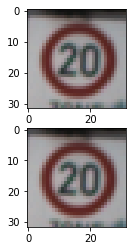

In [ ]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


use_cuda=True
image_nc=3
batch_size = 128

gen_input_nc = image_nc

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# load the pretrained model
pretrained_model = "/content/drive/MyDrive/adversarial/model_40.pth"
target_model = GTSRB_Net().to(device)
target_model.load_state_dict(torch.load(pretrained_model))
target_model.eval()

# load the generator of adversarial examples
pretrained_generator_path = '/content/drive/MyDrive/adversarial/netG_epoch_1.pth'
pretrained_G = Generator(gen_input_nc, image_nc).to(device)
pretrained_G.load_state_dict(torch.load(pretrained_generator_path))
pretrained_G.eval()

# test adversarial examples in MNIST training dataset
opt = {"dataroot": '/content/drive/MyDrive/adversarial/GTSRB/Final_Training/Images', 
   "batch_size": 1,
   "transform": None,
   "mode": "train", 
   "annotations": annotations,
   'transform': transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()])}
dataset = GTSRB_dataloader(opt)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = opt["batch_size"], shuffle=False)
#dataset = torchvision.datasets.MNIST('./dataset', train=True, transform=transforms.ToTensor(), download=True)
#train_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
num_correct = 0
for i, image in enumerate(dataloader, 0):
    test_img,test_target = image['image'],image['annotation']
    test_label = test_target['label']
    test_img, test_label = test_img.to(device), test_label.to(device)
    perturbation = pretrained_G(test_img)
    #print(perturbation.shape,test_img.shape)
    perturbation = torch.clamp(perturbation, -0.3, 0.3)

    
    adv_img = perturbation + test_img
    adv_img = torch.clamp(adv_img, 0, 1)
    if i ==100: 
      img = adv_img.detach().cpu().numpy()
      img = np.squeeze(img, axis=0)
      img = np.transpose(img, (1,2,0))

      img2 = test_img.detach().cpu().numpy()
      img2 = np.squeeze(img2, axis=0)
      img2 = np.transpose(img2, (1,2,0))

      figure, axis = plt.subplots(2, 1)
      axis[0].imshow(img)
      axis[1].imshow(img2)
      break


    pred_lab = torch.argmax(target_model(adv_img),1)
    num_correct += torch.sum(pred_lab==test_label,0)

print('GTSRB training dataset:')
print('num_correct: ', num_correct.item())
print('accuracy of adv imgs in training set: %f\n'%(num_correct.item()/len(dataset)))

# test adversarial examples in MNIST testing dataset
# mnist_dataset_test = torchvision.datasets.MNIST('./dataset', train=False, transform=transforms.ToTensor(), download=True)
# test_dataloader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)
# num_correct = 0
# for i, data in enumerate(test_dataloader, 0):
#     test_img, test_label = data
#     test_img, test_label = test_img.to(device), test_label.to(device)
#     perturbation = pretrained_G(test_img)
#     perturbation = torch.clamp(perturbation, -0.3, 0.3)
#     adv_img = perturbation + test_img
#     adv_img = torch.clamp(adv_img, 0, 1)
#     pred_lab = torch.argmax(target_model(adv_img),1)
#     num_correct += torch.sum(pred_lab==test_label,0)

# print('num_correct: ', num_correct.item())
# print('accuracy of adv imgs in testing set: %f\n'%(num_correct.item()/len(mnist_dataset_test)))

#**Attack Success Rate Calculation**

In [ ]:
len(dataset)

39209